In [1]:
import os
import pandas as pd
import numpy as np
import math
import gensim
import random
from itertools import chain
import torch
import dgl
import dgl.function as fn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score,recall_score,precision_score
from gensim.models import KeyedVectors
import re
from itertools import combinations
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pickle
from tokenizers import  BertWordPieceTokenizer
from transformers import BertTokenizer,BertModel
from pytorchtools import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pytorchtools import EarlyStopping

Using backend: pytorch


In [2]:


LABELS = 3
MAX_LENGTH =  60#36 
PIXEL = 49
BATCH_SIZE = 16
DEVICE = 'cuda:0'
WINDOWS = 2
NB_EPOCH = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


## build graph

In [3]:

def get_batch_graph(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows,max_len+1):
            t = range(j-windows,j)
            edges = np.array(list(combinations(t,2)))
            for edge in edges:
                g.add_edges(edge[0],edge[1])
                g.add_edge(edge[1], edge[0])
#         g.add_edge(max_length -1, 0)

        batch_graph.append(g)
    return batch_graph

def get_fusion_batch(batch_size,max_len,pixel):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len + pixel)
    
        # text with pixel
        for j in range(max_len,max_len + pixel):
            for i in range(0,max_len):
                g.add_edges(i,j)
                g.add_edge(j, i)
        
        batch_graph.append(g)
        
    return batch_graph
    


batch_graph = get_batch_graph(BATCH_SIZE, MAX_LENGTH, WINDOWS)
batch_fusion_graph = get_fusion_batch(BATCH_SIZE, MAX_LENGTH, PIXEL)

def get_next_batch(batch_size,batch_graph = batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    bg = bg.to(torch.device(DEVICE))
    return bg

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


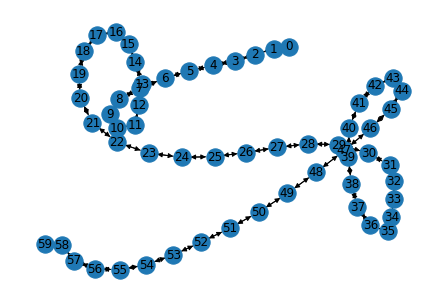

In [4]:

import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


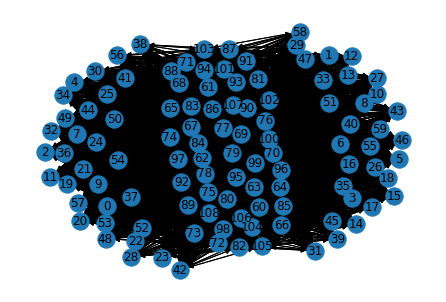

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_fusion_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


In [6]:
 
def read_text(path):
    with open(path,mode='r',encoding='gbk') as f:
        text = f.read()
        text = text.strip().lower().replace('#',' # ')
    return str(text)



def read_img(path,tfms):
    img = tfms(Image.open(path)).unsqueeze(0)
    return img


def load_data():
    
    # Preprocess image
    tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

    texts = []
    images = torch.Tensor()
    y = []
    index_ID_dict = {}
    all_data = pd.read_csv('./dataset/MVSA_Single/labelResultAll.csv')
    for index,row in all_data.iterrows():
        ID = row['ID']
        index_ID_dict[index] = ID
        if ID%100 == 0:
            print(ID)
        label = row['label']
        y.append(label)
        text_path = os.path.join('./dataset/MVSA_Single/data/', str(ID)+'.txt')
        texts.append(read_text(text_path))
    #     image_path = os.path.join('./dataset/MVSA_Single/data/', str(ID)+'.jpg')
    #     image = read_img(image_path,tfms)
    #     if images.shape[0] ==0:
    #         images = image
    #     else:
    #         images = torch.cat([images, image], 0)



    label_dict = {'negative' : 0, 'neutral' : 1, 'positive' : 2 }
    y = [label_dict[l] for l in y]
    y = np.array(y)

    # torch.save(images,'./dataset/single_images.pkl')
    # torch.save(y,'./dataset/single_y.pkl')

    images = torch.load('./dataset/single_images.pkl')
    
    return texts,images,y

def get_token_text(texts,max_length):
    pad = np.array([102] * max_length)
    texts_tmp = []

    for t  in texts:
        token = tokenizer(t,return_tensors = 'pt')['input_ids'].numpy()[0]
        if len(token)>= max_length:
            token = token[0:max_length]
        else:
            token = np.concatenate((token,pad[0:max_length-len(token)])) 
        token = np.reshape(token,(1,-1))
        if len(texts_tmp)==0:
            texts_tmp = token
        else:
            texts_tmp = np.vstack((texts_tmp,token))

    x_texts  = texts_tmp   
    
    return x_texts

def get_data_loader(shuffle_index,fold_index,fold_N = 10):
    fold_sample_num = len(shuffle_index)//fold_N
    test_index = shuffle_index[fold_sample_num * fold_index : fold_sample_num * (fold_index+1)]
    train_val_index = np.concatenate((shuffle_index[0:fold_sample_num * fold_index],shuffle_index[fold_sample_num * (fold_index+1):])).astype(int)
    train_index = train_val_index[0: -fold_sample_num]
    val_index = train_val_index[-fold_sample_num:]
    
    print('test_index:{begin}==>{end}'.format(begin = fold_sample_num * fold_index,end =  fold_sample_num * (fold_index+1)))


    
    train_texts = x_texts[train_index]
    train_images = images[train_index]
    train_y = y[train_index]
    
    val_texts = x_texts[val_index]
    val_images = images[val_index]
    val_y = y[val_index]
    
    test_texts = x_texts[test_index]
    test_images = images[test_index]
    test_y = y[test_index]

    train_set = data.TensorDataset(torch.LongTensor(train_texts),torch.FloatTensor(train_images) ,torch.LongTensor(train_y))
    val_set = data.TensorDataset(torch.LongTensor(val_texts),torch.FloatTensor(val_images), torch.LongTensor(val_y))
    test_set = data.TensorDataset(torch.LongTensor(test_texts),torch.FloatTensor(test_images), torch.LongTensor(test_y))

    train_data_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                             shuffle=True)
    val_data_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    test_data_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    
    return train_data_loader,val_data_loader,test_data_loader

texts,images,y = load_data()
x_texts = get_token_text(texts,MAX_LENGTH)


100
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1700
1800
1900
2000
2100
2500
2600
2700
2800
2900
3100
3200
3300
3400
3500
3600
3700
3800
4000
4100
4200
4300
4500
4600
4700
4800
5000
5100


In [7]:
class GAT(nn.Module):
    def __init__(self, input_dim,output_dim, activation):
        super(GAT, self).__init__()
       
        self.norm = nn.BatchNorm1d(input_dim)
        self.merge_linner =  nn.Linear( input_dim , output_dim)
        self.activation = activation
        self.fc = nn.Linear(input_dim, input_dim, bias=False)
        self.attn_fc = nn.Linear(2 * input_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(z2)
        return { 'e': F.leaky_relu(a)}
    
    def message_func(self, edges):
        return {'h': edges.src['h'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)  
        h_ = nodes.data['h']
#         # equation (4)
        h = torch.sum(alpha * nodes.mailbox['h'], dim=1)
        h = 0.9 * h + 0.1 * h_
        h = self.merge_linner(h)
        h = self.activation(h)
        
        return {'h': h}
    
    def forward(self, bg, h):

        # equation (1)
        h = self.fc(h)
        bg.ndata['h'] = h
        # equation (2)
        bg.apply_edges(self.edge_attention)
        # equation (3) & (4)
        bg.update_all(self.message_func, self.reduce_func)
        
        return bg.ndata.pop('h')
    

    
class SelfAttention(nn.Module):
    # refrence:https://blog.csdn.net/uhauha2929/article/details/81951760
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
#         print('weight',weights)
        # (B, L, H) * (B, L, 1) -> (B, H)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class Classifier(nn.Module):
    def __init__(self, labels,max_length,pixel,hidden_size = 768,drop_rate = 0.4):
        super(Classifier, self).__init__()
        self.labels = labels

        self.dropout = nn.Dropout(drop_rate)
        self.hidden_size = hidden_size
        self.bert_model = BertModel.from_pretrained('bert-base-uncased',return_dict = True)
        self.text_normal = nn.LayerNorm((max_length,self.hidden_size))
        self.image_normal = nn.LayerNorm((pixel,self.hidden_size))
        
        self.GAT = GAT(self.hidden_size, self.hidden_size, F.relu)
        self.att = SelfAttention(self.hidden_size)
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.image_trans = nn.Linear(1280, self.hidden_size)

        self.classify_h = nn.Linear(self.hidden_size , self.hidden_size)
        self.classify = nn.Linear(self.hidden_size, labels)

    def forward(self,text,image):
        
        bs = text.shape[0]
        bg = get_next_batch(bs)
        bg_fusion = get_next_batch(bs,batch_graph = batch_fusion_graph)
        
        text = self.bert_model(text).last_hidden_state
#         text = torch.reshape(text,(bs,-1,self.hidden_size))   #[bs,max_len,hidden_size]
        text = self.text_normal(text)
        with torch.no_grad():
            img = self.image_model.extract_features(image) #[bs,1280,7,7]  1536
        img = torch.reshape(img,(bs,1280,49))   #[bs,1280,49]
        img = torch.transpose(img,1,2)          #[bs,49,1280]
        img =  torch.reshape(img,(-1,1280))     #[bs*49,1280]
        img = self.image_trans(img)             #[bs*49,hidden_size]
        img = torch.reshape(img,(bs,-1,self.hidden_size))   #[bs,49,hidden_size]
#         img = self.image_normal(img)

        feature = torch.cat([text, img], 1)
        feature_short = torch.reshape(feature,(-1,feature.shape[2]))

        gat_feature = self.GAT(bg_fusion, feature_short)
#         head_feature = self.multi_head(gat_feature,bs)
        feature = feature_short + gat_feature
        feature = torch.reshape(feature,(bs,-1,feature.shape[-1]))
        feature = self.att(feature)
        
#         feature = torch.cat([feature_short, gat_feature,head_feature], 1)
#         feature = torch.reshape(feature,(bs,-1))
        feature = self.dropout(feature)
        
        feature = self.classify_h(feature)
        feature = F.relu(feature)
        
        return self.classify(feature)

    
def model_test(data_loader,model,report = False):
    '''
    使用验证集或测试集测试模型
    '''
    pred_Y = []
    test_Y = []
    loss_l = []
    loss_func = nn.CrossEntropyLoss()
    for step,(b_texts,b_image_features, test_y_batch) in enumerate(data_loader):

        
        b_texts = b_texts.to(torch.device(DEVICE))
        b_image_features = b_image_features.to(torch.device(DEVICE))
        test_y_batch = test_y_batch.to(torch.device(DEVICE))
        
        test_net_out = model(b_texts,b_image_features)
        loss = loss_func(test_net_out, test_y_batch) 
        loss_l.append(loss.cpu().data.numpy())
        
        test_net_out = test_net_out.cpu().data.numpy()
        pred_y_batch = np.argmax(test_net_out,axis = 1)
        pred_Y = np.concatenate((pred_Y,pred_y_batch), axis=0) 
        test_Y = np.concatenate((test_Y,test_y_batch.cpu().data.numpy()), axis=0)
    
    if report:
        print(classification_report(test_Y,pred_Y,digits = 5))
    f1_macro = f1_score(test_Y,pred_Y,average='macro')
    f1_weighted = f1_score(test_Y,pred_Y,average='weighted')
    acc = accuracy_score(test_Y,pred_Y)
    loss_mean = np.mean(np.array(loss_l))
    
    return f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean


def draw_cofusion_matrix(test_Y,pred_Y, labels=[0, 1, 2]):
    sns.set()
    
    plt.figure(figsize=(300, 300))
    f,ax=plt.subplots()
    C2= confusion_matrix(test_Y,pred_Y, labels=[0, 1, 2],normalize = 'true')
    print(C2) #打印出来看看
    sns.heatmap(C2,annot=True,ax=ax,cmap="YlGnBu") #画热力图

    labels = ['negative','neutral','positive']
    ax.set_title('confusion matrix') #标题
    ax.set_xticklabels( labels) 
    ax.set_yticklabels(labels) 
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    plt.show()

test_index:0==>451
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.08
epoch:0, step:100, loss:0.91
epoch:0, step:200, loss:0.75
*** 0.5031286434601352 0.6478805470585554 0.6984478935698448
0.60078826851499, best: 0.60078826851499
epoch:1, step:0, loss:0.60
epoch:1, step:100, loss:1.14
epoch:1, step:200, loss:0.40
*** 0.598756331176972 0.7164851389203472 0.7272727272727273
0.6630145292248497, best: 0.6630145292248497
epoch:2, step:0, loss:0.31
epoch:2, step:100, loss:0.13
epoch:2, step:200, loss:0.85
*** 0.6011162347917968 0.7142777395635191 0.7184035476718403
0.6597598912318186, best: 0.6630145292248497
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.18
epoch:3, step:100, loss:0.32
epoch:3, step:200, loss:0.49
*** 0.5785350756074947 0.6988991084010199 0.7117516629711752
0.6451433692893349, best: 0.6630145292248497
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.08
epoch:4, step:100, loss:0.22
epoch:4, step:200, loss:0.12
*** 0.5623332342154822 

<Figure size 21600x21600 with 0 Axes>

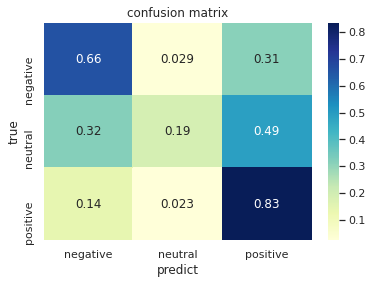

test_index:451==>902
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.13
epoch:0, step:100, loss:0.96
epoch:0, step:200, loss:0.58
*** 0.5610679701292478 0.6880510920164941 0.6917960088691796
0.6264319894992136, best: 0.6264319894992136
epoch:1, step:0, loss:0.91
epoch:1, step:100, loss:0.62
epoch:1, step:200, loss:0.24
*** 0.5777830512049782 0.7123369432339534 0.7317073170731707
0.6547451841390745, best: 0.6547451841390745
epoch:2, step:0, loss:0.40
epoch:2, step:100, loss:0.41
epoch:2, step:200, loss:0.50
*** 0.580437752174539 0.7010352424243488 0.7095343680709535
0.6449860601227462, best: 0.6547451841390745
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.12
epoch:3, step:100, loss:0.14
epoch:3, step:200, loss:0.31
*** 0.5927408382707923 0.6920999782503661 0.6851441241685144
0.6389424812196534, best: 0.6547451841390745
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.04
epoch:4, step:100, loss:0.16
epoch:4, step:200, loss:0.45
*** 0.58786692141

<Figure size 21600x21600 with 0 Axes>

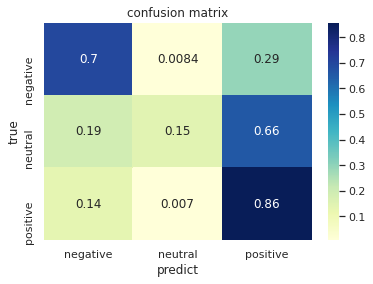

test_index:902==>1353
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09
epoch:0, step:100, loss:0.66
epoch:0, step:200, loss:0.75
*** 0.5355684313469835 0.6874564600719062 0.7095343680709535
0.6225513997089684, best: 0.6225513997089684
epoch:1, step:0, loss:0.69
epoch:1, step:100, loss:0.65
epoch:1, step:200, loss:0.51
*** 0.6109790375563006 0.731250927815033 0.7427937915742794
0.67688641456529, best: 0.67688641456529
epoch:2, step:0, loss:0.52
epoch:2, step:100, loss:0.42
epoch:2, step:200, loss:0.46
*** 0.5909858274026352 0.7143123828648481 0.738359201773836
0.6646725145882355, best: 0.67688641456529
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.44
epoch:3, step:100, loss:0.37
epoch:3, step:200, loss:0.25
*** 0.571343766864544 0.6812408235940282 0.6807095343680709
0.6260266506163075, best: 0.67688641456529
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.46
epoch:4, step:100, loss:0.69
epoch:4, step:200, loss:0.07
*** 0.5656889983923953 0.6

<Figure size 21600x21600 with 0 Axes>

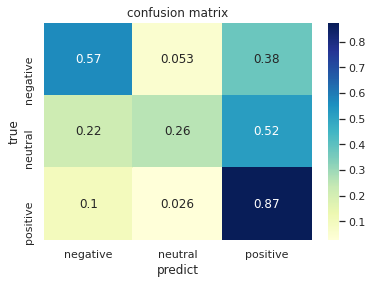

test_index:1353==>1804
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.08
epoch:0, step:100, loss:0.89
epoch:0, step:200, loss:0.55
*** 0.5686861784008029 0.704089840583119 0.7228381374722838
0.6457621579365433, best: 0.6457621579365433
epoch:1, step:0, loss:0.79
epoch:1, step:100, loss:0.37
epoch:1, step:200, loss:0.90
*** 0.5752177083094409 0.7182203554621456 0.738359201773836
0.6567884550416384, best: 0.6567884550416384
epoch:2, step:0, loss:0.23
epoch:2, step:100, loss:0.35
epoch:2, step:200, loss:0.78
*** 0.5560502022399629 0.6811751034495068 0.6807095343680709
0.6183798683040169, best: 0.6567884550416384
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.30
epoch:3, step:100, loss:0.21
epoch:3, step:200, loss:0.47
*** 0.5944081946965987 0.7067704851391488 0.7095343680709535
0.6519712813837761, best: 0.6567884550416384
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.60
epoch:4, step:100, loss:0.03
epoch:4, step:200, loss:0.31
*** 0.5768867603

<Figure size 21600x21600 with 0 Axes>

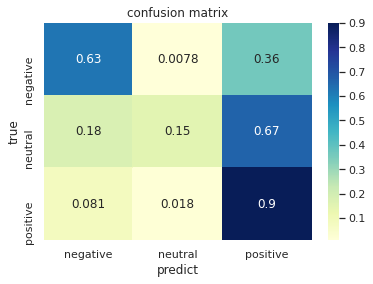

test_index:1804==>2255
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.07
epoch:0, step:100, loss:1.04
epoch:0, step:200, loss:0.88
*** 0.5485494456606025 0.6818606647243814 0.6940133037694013
0.6212813747150019, best: 0.6212813747150019
epoch:1, step:0, loss:0.59
epoch:1, step:100, loss:0.81
epoch:1, step:200, loss:0.47
*** 0.57804299311087 0.7109213905030729 0.7250554323725056
0.6515492127416878, best: 0.6515492127416878
epoch:2, step:0, loss:0.51
epoch:2, step:100, loss:0.31
epoch:2, step:200, loss:0.55
*** 0.5632896113301682 0.6899805284145439 0.6962305986696231
0.6297601049998957, best: 0.6515492127416878
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.29
epoch:3, step:100, loss:0.30
epoch:3, step:200, loss:0.16
*** 0.5638293809905678 0.6809320513038705 0.6762749445676275
0.6200521627790976, best: 0.6515492127416878
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.49
epoch:4, step:100, loss:0.70
epoch:4, step:200, loss:0.04
*** 0.5632505175

<Figure size 21600x21600 with 0 Axes>

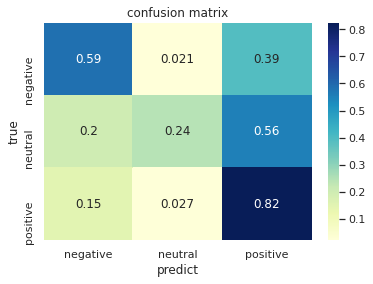

test_index:2255==>2706
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.04
epoch:0, step:100, loss:0.82
epoch:0, step:200, loss:0.87
*** 0.5473894630343912 0.6912544642989 0.720620842572062
0.6340051528032267, best: 0.6340051528032267
epoch:1, step:0, loss:0.73
epoch:1, step:100, loss:0.66
epoch:1, step:200, loss:0.52
*** 0.58856026487915 0.7013237264290583 0.7028824833702882
0.6457213741247192, best: 0.6457213741247192
EarlyStopping counter: 1 out of 3
epoch:2, step:0, loss:0.43
epoch:2, step:100, loss:0.25
epoch:2, step:200, loss:0.52
*** 0.6080541694576782 0.7211412269178636 0.7272727272727273
0.6676634483652027, best: 0.6676634483652027
EarlyStopping counter: 2 out of 3
epoch:3, step:0, loss:0.28
epoch:3, step:100, loss:0.45
epoch:3, step:200, loss:0.18
*** 0.5739750134762344 0.6779985245219656 0.6740576496674058
0.6240163315718201, best: 0.6676634483652027
EarlyStopping counter: 3 out of 3
Early stopping
run time: 151.0211136341095
              precision    r

<Figure size 21600x21600 with 0 Axes>

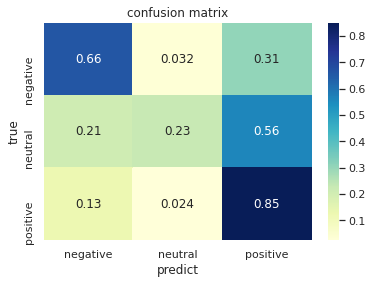

test_index:2706==>3157
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.12
epoch:0, step:100, loss:0.41
epoch:0, step:200, loss:0.83
*** 0.5659005186232909 0.717427404761382 0.7427937915742794
0.6543471550987852, best: 0.6543471550987852
epoch:1, step:0, loss:0.45
epoch:1, step:100, loss:0.60
epoch:1, step:200, loss:0.99
*** 0.5933565734537235 0.7110165406360663 0.7184035476718403
0.6558800605627819, best: 0.6558800605627819
EarlyStopping counter: 1 out of 3
epoch:2, step:0, loss:0.51
epoch:2, step:100, loss:0.77
epoch:2, step:200, loss:0.42
*** 0.5657187248513856 0.69321949486042 0.6984478935698448
0.6320833092106153, best: 0.6558800605627819
EarlyStopping counter: 2 out of 3
epoch:3, step:0, loss:0.41
epoch:3, step:100, loss:0.33
epoch:3, step:200, loss:0.02
*** 0.5623772704958272 0.6905536107509956 0.6940133037694013
0.6281952871326142, best: 0.6558800605627819
EarlyStopping counter: 3 out of 3
Early stopping
run time: 146.5810317993164
              precision  

<Figure size 21600x21600 with 0 Axes>

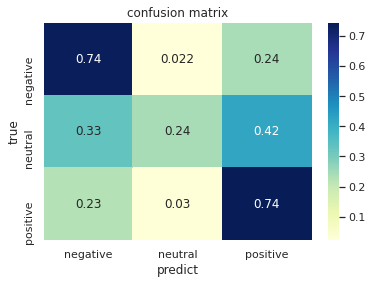

test_index:3157==>3608
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.10
epoch:0, step:100, loss:0.61
epoch:0, step:200, loss:0.70
*** 0.5598152063268342 0.7159323863082951 0.7427937915742794
0.6513044989505568, best: 0.6513044989505568
epoch:1, step:0, loss:0.47
epoch:1, step:100, loss:0.62
epoch:1, step:200, loss:0.52
*** 0.5496027228008494 0.7051242342691861 0.729490022172949
0.6395463724868993, best: 0.6513044989505568
EarlyStopping counter: 1 out of 3
epoch:2, step:0, loss:0.60
epoch:2, step:100, loss:0.98
epoch:2, step:200, loss:0.55
*** 0.5862078411230954 0.7164089844288273 0.7339246119733924
0.660066226548244, best: 0.660066226548244
EarlyStopping counter: 2 out of 3
epoch:3, step:0, loss:0.21
epoch:3, step:100, loss:0.46
epoch:3, step:200, loss:0.20
*** 0.5479742831007014 0.682401593191709 0.6851441241685144
0.6165592036346079, best: 0.660066226548244
EarlyStopping counter: 3 out of 3
Early stopping
run time: 146.91831064224243
              precision   

<Figure size 21600x21600 with 0 Axes>

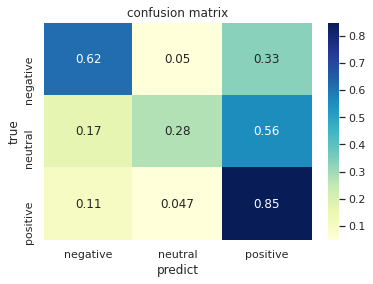

test_index:3608==>4059
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.08
epoch:0, step:100, loss:0.79
epoch:0, step:200, loss:0.72
*** 0.5430514296661663 0.6849646850965139 0.6984478935698448
0.6207496616180055, best: 0.6207496616180055
epoch:1, step:0, loss:0.37
epoch:1, step:100, loss:0.77
epoch:1, step:200, loss:0.79
*** 0.5919115864008924 0.7041360227994565 0.7095343680709535
0.6507229772359229, best: 0.6507229772359229
epoch:2, step:0, loss:0.46
epoch:2, step:100, loss:0.42
epoch:2, step:200, loss:0.56
*** 0.5899597015450674 0.7008963176423022 0.70509977827051
0.6475297399077886, best: 0.6507229772359229
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.30
epoch:3, step:100, loss:0.16
epoch:3, step:200, loss:0.29
*** 0.5925828455471157 0.6903139434116893 0.6807095343680709
0.6366461899575933, best: 0.6507229772359229
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.25
epoch:4, step:100, loss:0.15
epoch:4, step:200, loss:0.02
*** 0.6081124180

<Figure size 21600x21600 with 0 Axes>

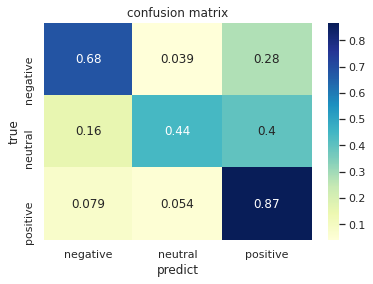

test_index:4059==>4510
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.07
epoch:0, step:100, loss:1.02
epoch:0, step:200, loss:0.49
*** 0.5708250143796684 0.7109076524341682 0.7272727272727273
0.6490488708261979, best: 0.6490488708261979
epoch:1, step:0, loss:0.38
epoch:1, step:100, loss:0.98
epoch:1, step:200, loss:0.86
*** 0.5764153375310902 0.7148905485644536 0.7339246119733924
0.6551699747522413, best: 0.6551699747522413
epoch:2, step:0, loss:0.46
epoch:2, step:100, loss:0.53
epoch:2, step:200, loss:0.78
*** 0.6364307084713304 0.7372061593485687 0.738359201773836
0.6873949551225832, best: 0.6873949551225832
EarlyStopping counter: 1 out of 3
epoch:3, step:0, loss:0.26
epoch:3, step:100, loss:0.57
epoch:3, step:200, loss:0.38
*** 0.6208369394330636 0.71953282088064 0.7117516629711752
0.6662943012021194, best: 0.6873949551225832
EarlyStopping counter: 2 out of 3
epoch:4, step:0, loss:0.12
epoch:4, step:100, loss:0.11
epoch:4, step:200, loss:0.52
*** 0.62696452544

<Figure size 21600x21600 with 0 Axes>

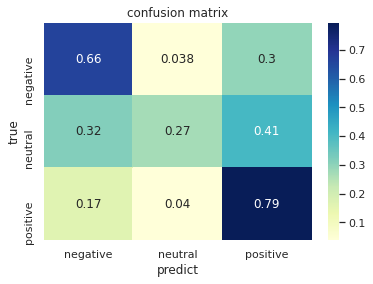

[0.5706513127491878, 0.57659403410487, 0.5867506877359094, 0.5816637784409999, 0.5718178145655518, 0.5972355604743459, 0.5798082098280314, 0.5963636363636363, 0.6755552875401012, 0.5842369582594794]
[0.687220246606754, 0.7190859397090613, 0.6999605366616825, 0.7371857720410789, 0.6758272660892815, 0.7033996872648841, 0.6861103970576982, 0.6947853255392059, 0.7679019833609759, 0.6999101384081204]
[0.70509977827051, 0.7405764966740577, 0.7161862527716186, 0.7583148558758315, 0.6895787139689579, 0.7184035476718403, 0.6917960088691796, 0.7073170731707317, 0.7716186252771619, 0.70509977827051]
max macro_f1:0.6755552875401012, max weight_f1:0.7679019833609759,max acc:0.7716186252771619
min macro_f1:0.5706513127491878, min weight_f1:0.6758272660892815,min acc:0.6895787139689579
mean macro_f1:0.5920677280062113, mean weight_f1:0.7071387292738742,mean acc:0.7203991130820399
mean run time: 172.48105113506318


In [8]:

shuffle_index = list(range(len(y)))
random.Random(1337).shuffle(shuffle_index) 

f1_macro_list = []
f1_weighted_list = []
acc_list = []
time_list = []

import time
for fold in range(10):
    begin = time.time()

    train_data_loader,val_data_loader,test_data_loader = get_data_loader(shuffle_index,fold)

    early_stopping = EarlyStopping( delta=1e-4, patience=3)

    #构造模型 
    net = Classifier(labels=LABELS,max_length = MAX_LENGTH,pixel = PIXEL)
    net.to(torch.device(DEVICE))


    optimizer = torch.optim.Adam(params = net.parameters(),
                                 lr = 2e-5)

    loss_func = nn.CrossEntropyLoss()

    begin = time.time()
    max_acc = 0
    # training and testing
    for epoch in range(NB_EPOCH):
        net.train()
        for step, (b_texts,b_image_features, b_y) in enumerate(train_data_loader):        # gives batch data
            b_texts = b_texts.to(torch.device(DEVICE))
            b_image_features = b_image_features.to(torch.device(DEVICE))
            b_y = b_y.to(torch.device(DEVICE))


            out = net(b_texts,b_image_features)                               # rnn output
            loss = loss_func(out, b_y) 
            if step %100 ==0:
                print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
            optimizer.zero_grad()                           # clear gradients for this training step
            loss.backward()                                 # backpropagation, compute gradients
            optimizer.step()                                # apply gradients

        net.eval()
        #每训练一轮，使用验证集验证
        f1_macro,f1_weighted,acc,test_Y,pred_Y,val_loss = model_test(val_data_loader,net)

        print('***',f1_macro,f1_weighted,acc)

        acc = (f1_macro+acc)/2
        if acc >max_acc:
            max_acc = acc
            torch.save(net, 'best_dgl_single.pkl')
        print('{acc}, best: {max_acc}'.format(acc = acc,max_acc = max_acc))

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print('run time:',time.time()-begin)
    time_list.append(time.time()-begin)
    net = torch.load('best_dgl_single.pkl')
    net.eval()

    f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean = model_test(test_data_loader, net,report = True)

    print('----***----',f1_macro,f1_weighted,acc)
    f1_macro_list.append(f1_macro)
    f1_weighted_list.append(f1_weighted)
    acc_list.append(acc)
    draw_cofusion_matrix(test_Y,pred_Y)


print(f1_macro_list)
print(f1_weighted_list)
print(acc_list)
print('max macro_f1:{macro_f1}, max weight_f1:{weight_f1},max acc:{acc}'.format(
    macro_f1 = max(f1_macro_list),weight_f1 = max(f1_weighted_list),acc = max(acc_list)))
print('min macro_f1:{macro_f1}, min weight_f1:{weight_f1},min acc:{acc}'.format(
    macro_f1 = min(f1_macro_list),weight_f1 = min(f1_weighted_list),acc = min(acc_list)))
print('mean macro_f1:{macro_f1}, mean weight_f1:{weight_f1},mean acc:{acc}'.format(
    macro_f1 = np.mean(f1_macro_list),weight_f1 = np.mean(f1_weighted_list),acc = np.mean(acc_list)))
print('mean run time: {time}'.format(time = np.mean(time_list)))



In [8]:
for ii in range(100):
    import IPython.display as display
    

    shuffle_index = list(range(len(y)))
    random.Random(1337).shuffle(shuffle_index) 

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []
    time_list = []

    import time
    for fold in range(10):
        begin = time.time()

        train_data_loader,val_data_loader,test_data_loader = get_data_loader(shuffle_index,fold)

        early_stopping = EarlyStopping( delta=1e-4, patience=3)

        #构造模型 
        net = Classifier(labels=LABELS,max_length = MAX_LENGTH,pixel = PIXEL)
        net.to(torch.device(DEVICE))


        optimizer = torch.optim.Adam(params = net.parameters(),
                                     lr = 2e-5)

        loss_func = nn.CrossEntropyLoss()

        begin = time.time()
        max_acc = 0
        # training and testing
        for epoch in range(NB_EPOCH):
            net.train()
            for step, (b_texts,b_image_features, b_y) in enumerate(train_data_loader):        # gives batch data
                b_texts = b_texts.to(torch.device(DEVICE))
                b_image_features = b_image_features.to(torch.device(DEVICE))
                b_y = b_y.to(torch.device(DEVICE))


                out = net(b_texts,b_image_features)                               # rnn output
                loss = loss_func(out, b_y) 
                if step %100 ==0:
                    print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
                optimizer.zero_grad()                           # clear gradients for this training step
                loss.backward()                                 # backpropagation, compute gradients
                optimizer.step()                                # apply gradients

            net.eval()
            #每训练一轮，使用验证集验证
            f1_macro,f1_weighted,acc,test_Y,pred_Y,val_loss = model_test(val_data_loader,net)

            print('***',f1_macro,f1_weighted,acc)

            acc = (f1_macro+acc)/2
            if acc >max_acc:
                max_acc = acc
                torch.save(net, 'best_dgl_single.pkl')
            print('{acc}, best: {max_acc}'.format(acc = acc,max_acc = max_acc))

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        print('run time:',time.time()-begin)
        time_list.append(time.time()-begin)
        net = torch.load('best_dgl_single.pkl')
        net.eval()

        f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean = model_test(test_data_loader, net,report = True)
        if acc < 0.68:
            display.clear_output(wait=True)
            break

        print('----***----',f1_macro,f1_weighted,acc)
        f1_macro_list.append(f1_macro)
        f1_weighted_list.append(f1_weighted)
        acc_list.append(acc)
        draw_cofusion_matrix(test_Y,pred_Y)


    print(f1_macro_list)
    print(f1_weighted_list)
    print(acc_list)
    print('max macro_f1:{macro_f1}, max weight_f1:{weight_f1},max acc:{acc}'.format(
        macro_f1 = max(f1_macro_list),weight_f1 = max(f1_weighted_list),acc = max(acc_list)))
    print('min macro_f1:{macro_f1}, min weight_f1:{weight_f1},min acc:{acc}'.format(
        macro_f1 = min(f1_macro_list),weight_f1 = min(f1_weighted_list),acc = min(acc_list)))
    print('mean macro_f1:{macro_f1}, mean weight_f1:{weight_f1},mean acc:{acc}'.format(
        macro_f1 = np.mean(f1_macro_list),weight_f1 = np.mean(f1_weighted_list),acc = np.mean(acc_list)))
    print('mean run time: {time}'.format(time = np.mean(time_list)))
    
    if np.min(acc_list)>0.68 and np.mean(acc_list)> 0.716 and  np.max(f1_macro_list) > 0.67:
        break
    else:
        display.clear_output(wait=True)


test_index:0==>451
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09
epoch:0, step:100, loss:0.66
epoch:0, step:200, loss:0.57
*** 0.5710568961116714 0.6960668487116838 0.7117516629711752
0.6414042795414233, best: 0.6414042795414233
epoch:1, step:0, loss:0.30
epoch:1, step:100, loss:0.34
epoch:1, step:200, loss:0.67


KeyboardInterrupt: 